In [259]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as grad
import matplotlib.pyplot as plt

import numpy as np
import time

import imageio

In [2]:
from IPython.display import clear_output
plot = True

## Implementation of base DE solver

In [3]:
class solver:
    """
    Base class for solving DE(differential equations)
    """
    
    def __init__(self, input_dim=1, output_dim=1, grid=None, net=None, **kwargs):
        """
        input_dim - number of independent input variables
        output_dim - number of output variables
        grid - torch tensor with shape (grid_size, input_dim)
        """
        
        if net is None:
            raise Exception('net must be not None')
        
        self.input_dim         = input_dim
        self.output_dim        = output_dim
        
        self.grid_size         = kwargs.get('grid_size', 0.1)
        self.epochs            = kwargs.get('epochs', 100)
        self.lr                = kwargs.get('lr', 0.001)
        self.nn                = net
        self.optim             = kwargs.get('optim', optim.Adam)(self.nn.parameters(), lr=self.lr)
        self.loss              = kwargs.get('loss', lambda x: x ** 2)
        self.grid              = grid
        self.ders              = {
            'left'   : lambda f_l, f_c, d: (f_c - f_l) / (d),
            'center' : lambda f_l, f_r, d: (f_r - f_l) / (2 * d),
            'right'  : lambda f_c, f_r, d: (f_r - f_c) / (d)
        }
    
    def derivatives(self, batch_grid=None, var_inds=[0]):
        
        batches_grds = []
        y_s          = []
        output       = []
        
        for var_ind in var_inds:
            
            D_l, D_r             = torch.tensor([[0.0] * self.input_dim]), torch.tensor([[0.0] * self.input_dim])
            D_l[0, var_ind]      = -self.grid_size
            D_r[0, var_ind]      = self.grid_size
            
            batch_grd            = batch_grid
            batch_grd_prev       = batch_grd + D_l 
            batch_grd_next       = batch_grd + D_r
            
            batches_grds += [(batch_grd_prev, batch_grd, batch_grd_next)]
            y_s          += [(self.nn(batch_grd_prev), self.nn(batch_grd), self.nn(batch_grd_next))]
            
        for (batch_grd_prev, batch_grd, batch_grd_next), (y_prev, y, y_next) in zip(batches_grds, y_s):
            
            
            dy_prev              = self.ders['left'](y_prev, y, self.grid_size) 
            dy_cur               = self.ders['center'](y_prev, y_next, self.grid_size) 
            dy_next              = self.ders['right'](y, y_next, self.grid_size) 

            d2y                  = self.ders['center'](dy_prev, dy_next, self.grid_size)
            
            output += [((batch_grd_prev, batch_grd, batch_grd_next), 
                        (y_prev, y, y_next), (dy_prev, dy_cur, dy_next), 
                        (d2y))]
            
        return output
        
    def calc_psi(self):
        pass
        
    def _train_step(self, shuffle=False):    
        
        """
            return loss
        """
        pass
    
    def _plot_e(self, axes=None, errors=None):
        axes.set_title("Error")
        axes.set_xlabel("#iteration")
        axes.set_ylabel("log(e)")
        axes.plot(np.log(errors), label='log(e)')
        axes.legend()
        axes.grid()
    
    def _plot_f(self, axes=None):
        pass
    
    def _plot(self, plt_f=False, plt_e=False, errors=None, **kwargs):
        figsize = kwargs.get('figsize', (8, 5))
        
        if plt_e and plt_f:
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
            axs = axes.flatten()
            self._plot_e(axes=axs[0], errors=errors)
            self._plot_f(axes=axs[1])
        elif plt_e:
            fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize)
            self._plot_e(axes=axes, errors=errors)
        elif plt_f:
            fig, axes = plt.subplots(nrows=1, ncols=1, figsize=figsize)
            self._plot_f(axes=axes)
        else:
            return
                
        plt.show()
    
    def train(self, shuffle=False, **kwargs):
        
        epochs    = self.epochs
        errors    = list()
        plot_f    = kwargs.get('plot_f', False)
        plot_e    = kwargs.get('plot_e', False)
        plot_cond = kwargs.get('plot_cond', lambda e: e % 250 == 0)
        
        for epoch in range(epochs):
            
            loss = 0
            
            self.optim.zero_grad()
            loss = self._train_step()
            
            loss.backward(retain_graph=True)
            self.optim.step()
            
            errors += [loss.item()]
            
            if plot_cond(epoch):
                
                clear_output()
                self._plot(plt_f=plot_f, plt_e=plot_e, errors=errors, **kwargs)

## ODE solving

In [243]:
class ODESolver(solver):
    """
        ODE solver
    """
    def __init__(self, input_dim=1, output_dim=1, grid=None, net=None, **kwargs):
        """
        input_dim - number of independent input variables
        output_dim - number of output variables
        grid - torch tensor with shape (grid_size, input_dim)
        """
        
        solver.__init__(self, input_dim=input_dim, output_dim=output_dim, grid=grid, net=net, **kwargs)
        
        
    def evaluate(self, INPUT=None):    
    
        y = self.nn(INPUT)
        return self.calc_psi(INPUT[:, 0], y[:, 0])
    
        
    def _plot_f(self, axes=None):
        axes.set_title("Solution")
        axes.set_xlabel("x")
        axes.set_ylabel("y")
        
        x = self.grid
        y = self.calc_psi(x, self.nn(x))
        
        x = x.detach().numpy()
        y = y.detach().numpy()
        
        axes.plot(x, y, label='Solution')
        axes.legend()
        axes.grid()
        
    def f(self, x_cur):
        return -1 - 2 * x_cur
        
    def calc_psi(self, x_cur, y_cur):
        return x_cur * (1 - x_cur) * y_cur
    
    def calc_dpsi(self, x_cur, y_cur, dy_cur):
        return (1 - 2 * x_cur) * y_cur + (x_cur - x_cur ** 2) * dy_cur
    
    def calc_d2psi(self, x_cur, y_cur, dy_cur, dy2_cur):
        return -2 * y_cur + (1 - 2 * x_cur) * dy_cur + (x_cur - x_cur ** 2) * dy2_cur
    
    def _train_step(self, shuffle=False):    
        
        """
            return loss
        """
        
        x, y, dy, d2y = self.derivatives(batch_grid=self.grid)[0]
        x_prev, x_cur, x_next = x
        y_prev, y_cur, y_next = y
        dy_prev, dy_cur, dy_next = dy
        d2y_cur = d2y[0]
        
        psi   = self.calc_psi(x_cur, y_cur)
        dpsi  = self.calc_dpsi(x_cur, y_cur, dy_cur)
        d2psi = self.calc_d2psi(x_cur, y_cur, dy_cur, d2y_cur)
        f     = self.f(x_cur)
        loss = ((d2psi + dpsi - f) ** 2).mean()
        
        return loss

In [261]:
# def plot_for_offset(t):

#     fig, ax = plt.subplots(figsize=(10, 5))
    
#     X = torch.arange(0, 1.001, 0.05)
#     X = X[:, None]

#     n = nn.Sequential(nn.Linear(1, 3), nn.ReLU(),
#                       nn.Linear(3, 1))
    
#     ode_solver = ODESolver(net=n, grid=X, epochs=t, grid_size=0.01)

#     ode_solver.train(plot_e=False, plot_f=False, figsize=(12, 7))
    
#     PSI = ode_solver.evaluate(ode_solver.grid)
#     x   = ode_solver.grid[:, 0].detach().numpy()
#     y   = PSI[:].detach().numpy()
    
#     ax.set_title("#Epochs - {}".format(t))
#     ax.plot(x, y, label='NN solution')
#     ax.plot(x, x * (1 - x), label='Analytical solution')
#     ax.grid()
#     ax.legend()
#     ax.set_ylim(0, (x * (1 - x)).max())

#     fig.canvas.draw()
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#     return image

# kwargs_write = {'fps':1.0, 'quantizer':'nq'}
# imageio.mimsave('./ode_per_epoch.gif', [plot_for_offset(i) for i in range(0, 1500, 100)], fps=3);

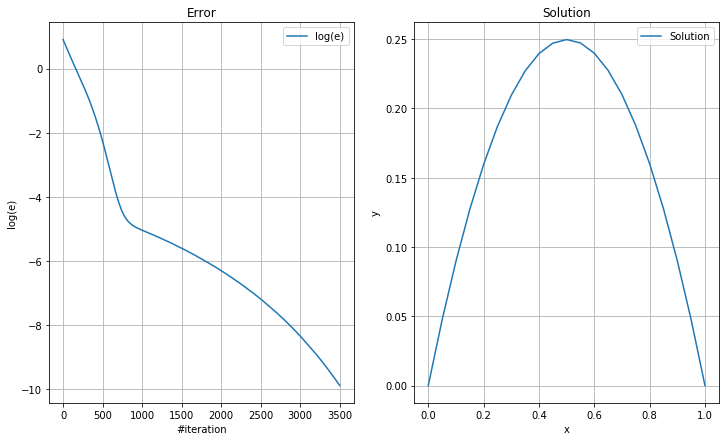

In [257]:
X = torch.arange(0, 1.001, 0.05)
X = X[:, None]

n = nn.Sequential(nn.Linear(1, 3), nn.ReLU(),
                  nn.Linear(3, 1))
ode_solver = ODESolver(net=n, grid=X, epochs=3501, grid_size=0.05)

ode_solver.train(plot_e=True, plot_f=True, figsize=(12, 7))

# PDE - transfer equation

In [162]:
class PDESolver(solver):
    """
        ODE solver
    """
    
    def __init__(self, input_dim=1, output_dim=1, grid=None, net=None, **kwargs):
        """
        input_dim  - number of independent input variables
        output_dim - number of output variables
        grid       - torch tensor with shape (grid_size, input_dim)
        """
        
        solver.__init__(self, input_dim=input_dim, output_dim=output_dim, grid=grid, net=net, **kwargs)
    
    def evaluate(self, INPUT=None):    
    
        y = self.nn(INPUT)
        return self.calc_psi(INPUT[:, 0, 0], INPUT[:, 0, 1], y[:, 0, 0])
    
    def f(self, x_cur, t_cur):
        return t_cur - t_cur ** 2 - 2 * x_cur * t_cur + 2 * x_cur * t_cur ** 2 + x_cur - x_cur ** 2 - 2 * t_cur * x_cur + 2 * t_cur * x_cur ** 2
        
    def calc_psi(self, x_cur, t_cur, y_cur):
        return (x_cur * (1 - x_cur) * t_cur * (1 - t_cur)) * y_cur
    
    def calc_dpsi_x(self, x_cur, t_cur, y_cur, dx_cur):
        return (-1 + t_cur) * t_cur * ((-1 + 2 * x_cur) * y_cur + (-1 + x_cur) * x_cur * dx_cur)
    
    def calc_dpsi_t(self, x_cur, t_cur, y_cur, dt_cur):
        return (-1 + x_cur) * x_cur * ((-1 + 2 * t_cur) * y_cur + (-1 + t_cur) * t_cur * dt_cur)
    
    def _train_step(self, shuffle=False):    
        """
            return loss
        """
        
        (x, yx, dyx, d2yx), (t, yt, dyt, d2yt) = self.derivatives(batch_grid=self.grid, var_inds=[0, 1])
        
        x_prev, x_cur, x_next = x
        t_prev, t_cur, t_next = t
        
        yx_prev, yx_cur, yx_next = yx
        yt_prev, yt_cur, yt_next = yt
        
        dy_prev_x, dy_cur_x, dy_next_x = dyx
        dy_prev_t, dy_cur_t, dy_next_t = dyt
        
        d2y_cur_x = d2yx[0]
        d2y_cur_t = d2yt[0]
        
        psi     = self.calc_psi(x_cur, t_cur, yx_cur)
        
        dpsi_x  = self.calc_dpsi_x(x_cur, t_cur, yx_cur, dy_cur_x)
        dpsi_t  = self.calc_dpsi_t(x_cur, t_cur, yx_cur, dy_cur_t)
        f       = self.f(x_cur, t_cur)
        
        loss = (((dpsi_t + dpsi_x - f) ** 2)).sum()
        
        return loss

In [214]:
n = nn.Sequential(nn.Linear(2, 3), nn.ReLU(),
                  nn.Linear(3, 1))

dx, dt = 0.01, 0.01

x = torch.arange(0, 1, dx)
t = torch.arange(0, 1, dt)

X, T = torch.meshgrid((x, t))

grid = torch.stack((X.reshape(-1, 1), T.reshape(-1, 1)), dim=1)[:, :, 0]
grid = grid[:, :, None]
grid = grid.transpose(2, 1)

pde_solver = PDESolver(net=n, grid=grid, input_dim=2, epochs=500, grid_size=0.01, lr=0.05)
%timeit pde_solver.train(plot_e=False, plot_f=False, figsize=(12, 7))

4.29 s ± 505 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [215]:
500, 4290

(500, 4290)

In [212]:
250, 1860

(250, 1860)

In [208]:
100, 739

(100, 739)

In [209]:
50, 394

(50, 394)

In [210]:
1, 9.55

(1, 9.55)

In [260]:
# PSI = pde_solver.evaluate(pde_solver.grid)

# def plot_for_offset(t):

#     fig, ax = plt.subplots(figsize=(10, 5))
    
#     x = pde_solver.grid[t::100, 0, 0].detach().numpy()
#     y = PSI[t::100].detach().numpy()
#     T = pde_solver.grid[100 * t, 0, 0].detach().numpy()
    
#     ax.plot(x, y, label='NN solution')
#     ax.plot(x, x * (1 - x) * T * (1 - T), label='Analytical solution')
#     ax.grid()
#     ax.legend()
#     ax.set_ylim(0, PSI.max().item())

#     fig.canvas.draw()
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

#     return image

# kwargs_write = {'fps':1.0, 'quantizer':'nq'}
# imageio.mimsave('./transfer_eq_25.gif', [plot_for_offset(i) for i in range(0, 100, 5)], fps=20);